## Imports

In [1]:
#Imports
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import string
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from keras.datasets import mnist
from keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from skimage.metrics import structural_similarity as ssim
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.optimize import minimize
from datetime import datetime

from Autoencoder import autoencoder
from Multiscale_network import multiscale_network

## Useful functions

In [2]:
# input: (60000,28,28); output: (60000,28,28,1)
def reshape_for_CNN(coarse_train,coarse_test,dim):

  coarse_train=np.reshape(coarse_train, (len(coarse_train), dim[0], dim[1], 1))
  coarse_test=np.reshape(coarse_test, (len(coarse_test), dim[0], dim[1], 1))
  return coarse_train,coarse_test

In [3]:
# take in (60000,28,28) ; specify dim to upscale; coarsen, normalize;   output: either (x1*x2) or (x1, x2, 1)
def upscale_normalize_reshape(train_x,test_x,dim,cnn):
# dim=(n,n); 
# train_x.shape - (60000,28,28)

    train_x=train_x.astype('float32')
    test_x= test_x.astype('float32')

    # coarsen training data
    coarse_train=np.zeros((train_x.shape[0],dim[0],dim[1]))
    for i in range(train_x.shape[0]):
        coarse_train[i] = cv2.resize(train_x[i], dim, interpolation = cv2.INTER_AREA)
        
    #coarsen test data
    coarse_test=np.zeros((test_x.shape[0],dim[0],dim[1]))
    for i in range(test_x.shape[0]):
        coarse_test[i] = cv2.resize(test_x[i], dim, interpolation = cv2.INTER_AREA)

    # normalize
    coarse_train=coarse_train.astype('float32') / np.absolute(coarse_train).max()
    coarse_test=coarse_test.astype('float32') / np.absolute(coarse_test).max()
    
    if cnn==True:
        coarse_train,coarse_test=reshape_for_CNN(coarse_train,coarse_test,dim)
    else:
        coarse_train=np.reshape(coarse_train, (len(coarse_train), dim[0]*dim[1]))
        coarse_test=np.reshape(coarse_test, (len(coarse_test), dim[0]*dim[1]))
    return coarse_train, coarse_test

In [4]:
# take 2 images and plot: 1) top: original 2) bottom: reconstruction
def plot_reconstruction1(original,reconstruction,dim1,dim2):


  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(original[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.title('Original fine test')

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstruction[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.title('Reconstructed test')
  plt.colorbar()
  plt.show()

In [5]:
# plot loss of a custom model by accessing history attribute of model
def plot_loss(history):
    plt.figure(figsize=(10,10))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['reg7x7_loss'])
    plt.plot(history.history['reg14x14_loss'])
    plt.plot(history.history['reg28x28_loss'])
    
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_reg7x7_loss'])
    plt.plot(history.history['val_reg14x14_loss'])
    plt.plot(history.history['val_reg28x28_loss'])
    
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_total','train7x7','train14x14','train28x28','val_total','val7x7','val14x14','val28x28'], loc='upper right')
    #plt.savefig('model1_leakyrelu.png', dpi=500)
    plt.show()

## Data Generation

In [6]:
gaussian_data = np.load(r'C:\Users\Mahammad\OneDrive\Desktop\USC_2021\Research\Data_assimilation\Multiscale_HM_ENKF\Multiscale_gradient_based\RSC_2023\Gaussian\gaussian_data_5000_16384.npy')
gaussian_data.shape

(5000, 16384)

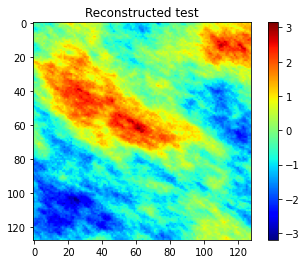

In [7]:
plt.imshow(gaussian_data[2,:].reshape(128, 128))
plt.jet()
plt.title('Reconstructed test')
plt.colorbar()
plt.show()

In [8]:
# Split to train, test

x_train=gaussian_data[:4500]          # 450
print(x_train.shape)
x_test=gaussian_data[4500:]        # 50
print(x_test.shape)


x_train=np.reshape(x_train, (len(x_train),128, 128))
x_test=np.reshape(x_test, (len(x_test), 128, 128))
print(x_train.shape)
print(x_test.shape)

(4500, 16384)
(500, 16384)
(4500, 128, 128)
(500, 128, 128)


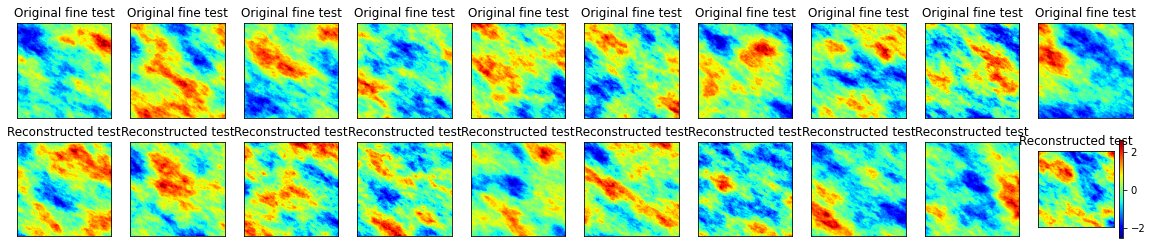

In [9]:
plot_reconstruction1(x_train,x_test,128,128)

(4500, 64, 64)
(500, 64, 64)
4.84133
-5.66942


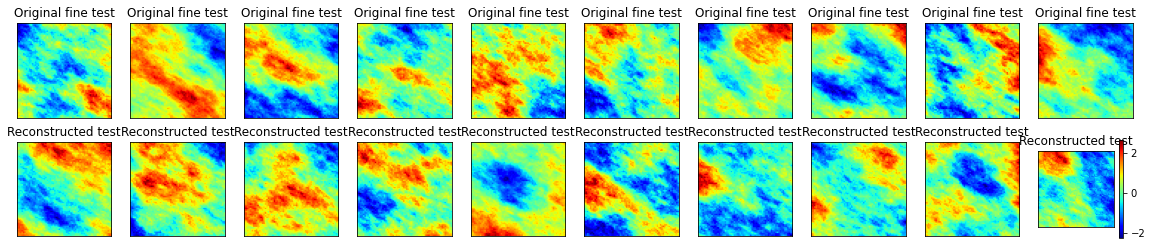

In [10]:
# Crop 64x64

x_train=x_train[:,32:96,32:96]
x_test=x_test[:,32:96,32:96]
print(x_train.shape)
print(x_test.shape)
print(x_train.max())
print(x_train.min())
plot_reconstruction1(x_train,x_test,64,64)

In [11]:
# Assign train data to 64x64

train64_64nd, test64_64nd=(x_train, x_test)
print(train64_64nd.shape)
print(np.histogram(train64_64nd))
print(train64_64nd.max())
print(train64_64nd.min())

(4500, 64, 64)
(array([    143,    2248,   85289, 1101297, 4889208, 7519845, 4048490,
        736990,   47729,     761], dtype=int64), array([-5.66942 , -4.618345, -3.56727 , -2.516195, -1.46512 , -0.414045,
        0.63703 ,  1.688105,  2.73918 ,  3.790255,  4.84133 ]))
4.84133
-5.66942


In [12]:
# upscale_reshape_normalize

train8_8dn, test8_8dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(8,8),cnn=False)
train8_8cnndn, test8_8cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(8,8),cnn=True)

train16_16dn, test16_16dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(16,16),cnn=False)
train16_16cnndn, test16_16cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(16,16),cnn=True)

train32_32dn, test32_32dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(32,32),cnn=False)
train32_32cnndn, test32_32cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(32,32),cnn=True)

train64_64dn, test64_64dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(64,64),cnn=False)
train64_64cnndn, test64_64cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(64,64),cnn=True)

#train28_28dn, test28_28dn=train28_28nd, test28_28nd
print(train8_8dn.shape)
print(train8_8cnndn.shape)
print(train16_16dn.shape)
print(train32_32dn.shape)
print(train64_64dn.shape)
print(train8_8dn.min())
print(train8_8dn.max())
print(train16_16dn.min())
print(train16_16dn.max())
print(train32_32dn.min())
print(train32_32dn.max())
print(train64_64dn.min())
print(train64_64dn.max())

(4500, 64)
(4500, 8, 8, 1)
(4500, 256)
(4500, 1024)
(4500, 4096)
-1.0
0.8137962
-1.0
0.8119334
-1.0
0.829532
-1.0
0.8539375


In [13]:
# Plot 3 large images
def plot_reconstruction1(original,reconstruction,dim1,dim2):


  n = 3
  plt.figure(figsize=(14, 7))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(original[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Original fine test')
      plt.title('Train')

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstruction[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Reconstructed test')
      plt.title('Test')
  plt.colorbar()
  plt.show()

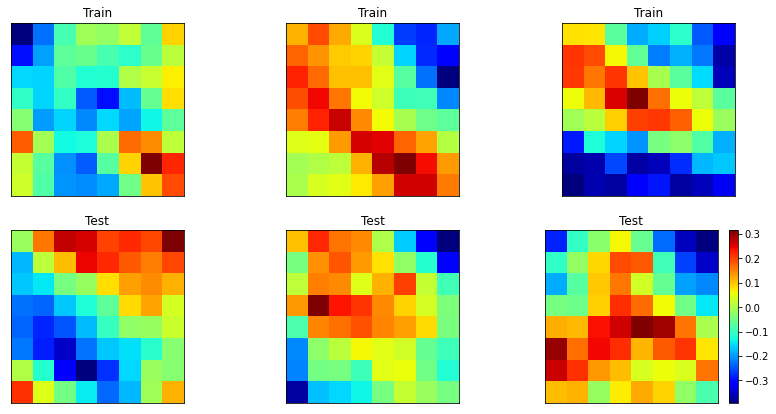

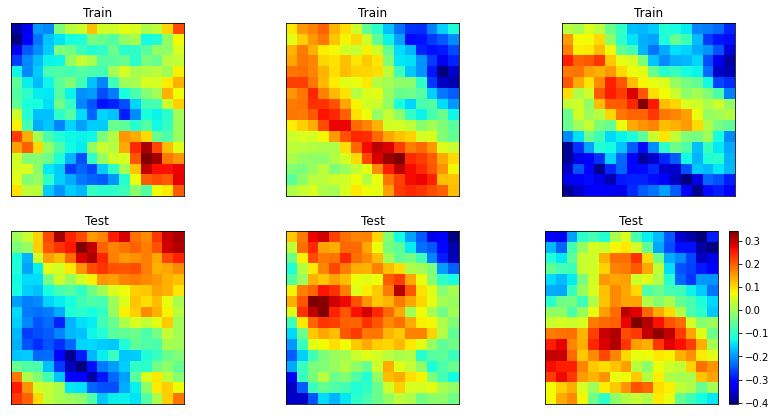

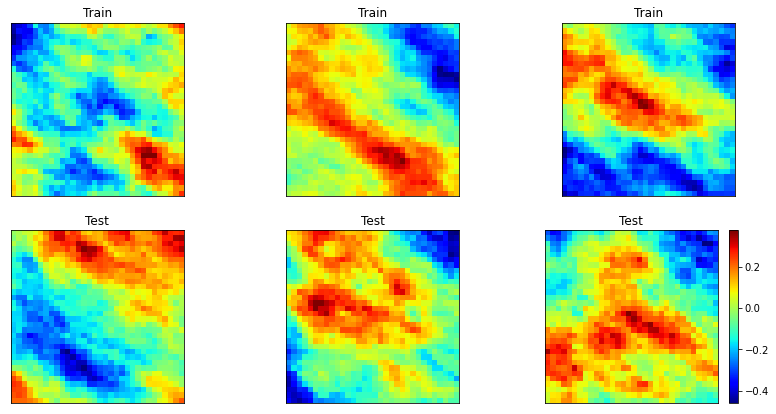

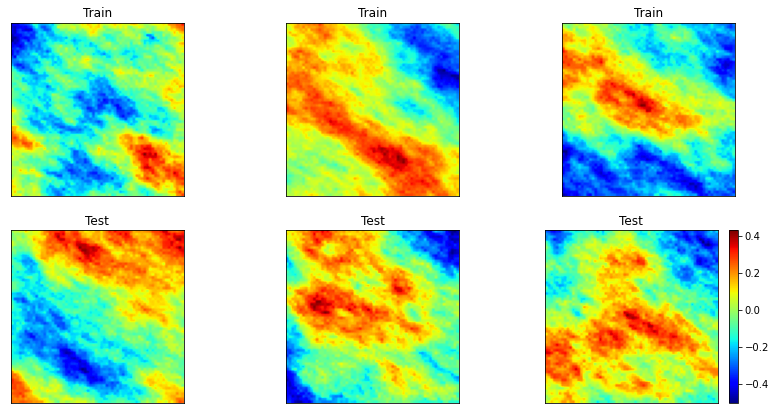

In [14]:
plot_reconstruction1(train8_8dn,test8_8dn,8,8)
#plot_reconstruction1(train5_5cnndn,test5_5cnndn,5,5)

plot_reconstruction1(train16_16dn,test16_16dn,16,16)
plot_reconstruction1(train32_32dn,test32_32dn,32,32)
plot_reconstruction1(train64_64dn,test64_64dn,64,64)

# Autoencoder training

# z=64

In [15]:
# define model
AE64=autoencoder(z_dim=64)
AE64.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         520       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0     

C:\Users\Mahammad\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
# train model
history_AE64=AE64.fit(train64_64cnndn, train64_64cnndn,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(test64_64cnndn,test64_64cnndn))

## Import model

In [16]:
AE64 = keras.models.load_model('AE64.h5')
AE64.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         520       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0     

In [17]:
#predict
pred64_64fAE64 = AE64.predict(test64_64cnndn)
print(pred64_64fAE64.shape)
print(str(pred64_64fAE64.min())+'  :64:   '+str(pred64_64fAE64.max()))

(500, 64, 64, 1)
-0.94023347  :64:   0.7691465


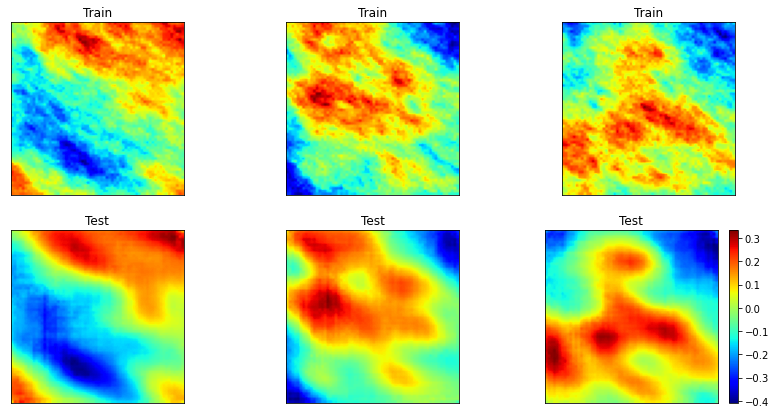

In [18]:
#plot predictions from model
plot_reconstruction1(test64_64dn,pred64_64fAE64,64,64)

# z=128

In [19]:
# define model
AE128=autoencoder(z_dim=128)
AE128.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 8)         520       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0   

In [ ]:
# train model
history_AE128=AE128.fit(train64_64cnndn, train64_64cnndn,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(test64_64cnndn,test64_64cnndn))

## Import model

In [20]:
AE128 = keras.models.load_model('AE128.h5')
AE128.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 8)         520       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0   

In [21]:
#predict
pred64_64fAE128 = AE128.predict(test64_64cnndn)
print(pred64_64fAE128.shape)
print(str(pred64_64fAE128.min())+':64:'+str(pred64_64fAE128.max()))

(500, 64, 64, 1)
-1.0171611:64:0.8743577


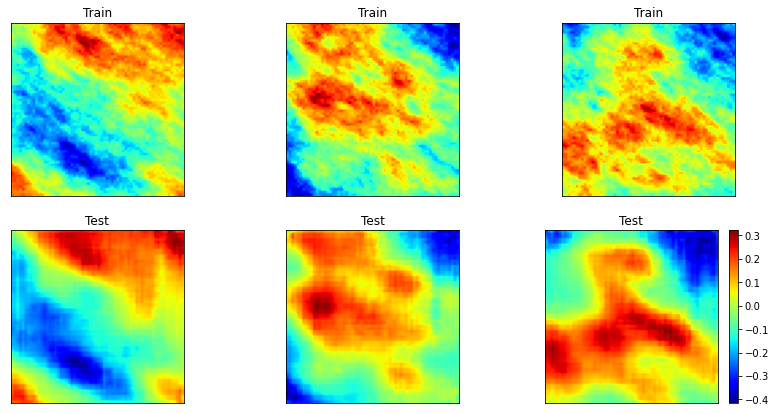

In [22]:
#plot predictions from model
plot_reconstruction1(test64_64dn,pred64_64fAE128,64,64)

# z=256

In [23]:
# define model
AE256=autoencoder(z_dim=256)
AE256.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 8)         520       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 8)         0   

In [ ]:
# train model
history_AE256=AE256.fit(train64_64cnndn, train64_64cnndn,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(test64_64cnndn,test64_64cnndn))

## Import model

In [24]:
AE256 = keras.models.load_model('AE256.h5')
AE256.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 8)         520       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 8)         0   

In [25]:
#predict
pred64_64fAE256 = AE256.predict(test64_64cnndn)
print(pred64_64fAE256.shape)
print(str(pred64_64fAE256.min())+':64:'+str(pred64_64fAE256.max()))

(500, 64, 64, 1)
-0.8684528:64:0.9340889


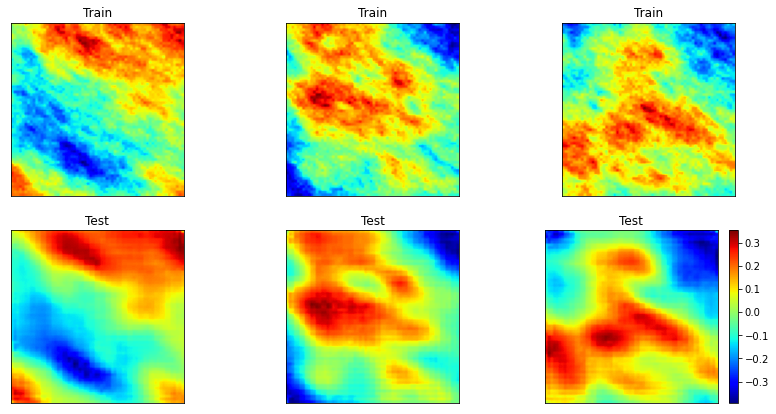

In [26]:
#plot predictions from model
plot_reconstruction1(test64_64dn,pred64_64fAE256,64,64)

# Multiscale model training

In [27]:
# define model
multiscale=multiscale_network()
multiscale.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 32)        4128      
_________________________________________________________________
x16 (Conv2DTranspose)        (None, 16, 16, 1)         289       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 32)        320 

In [ ]:
# train model
history_multiscale=multiscale.fit(train8_8cnndn, [train16_16cnndn,train32_32cnndn,train64_64cnndn],
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(test8_8cnndn,[test16_16cnndn,test32_32cnndn, test64_64cnndn ]))

## Import model

In [28]:
multiscale = keras.models.load_model('multiscale.h5')
multiscale.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 32)        4128      
_________________________________________________________________
x16 (Conv2DTranspose)        (None, 16, 16, 1)         289       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        320   

(500, 16, 16, 1)


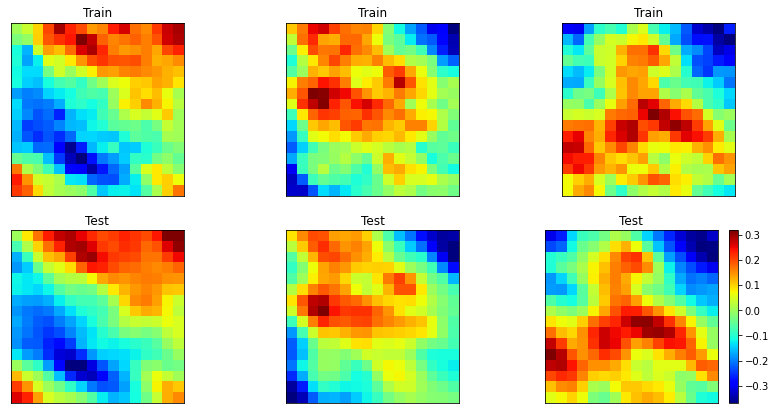

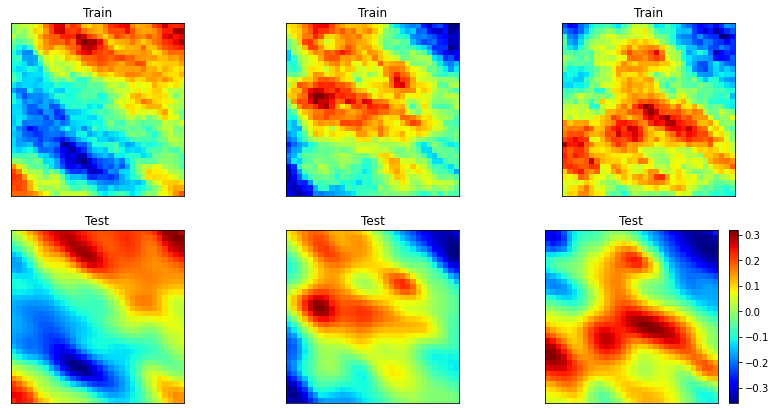

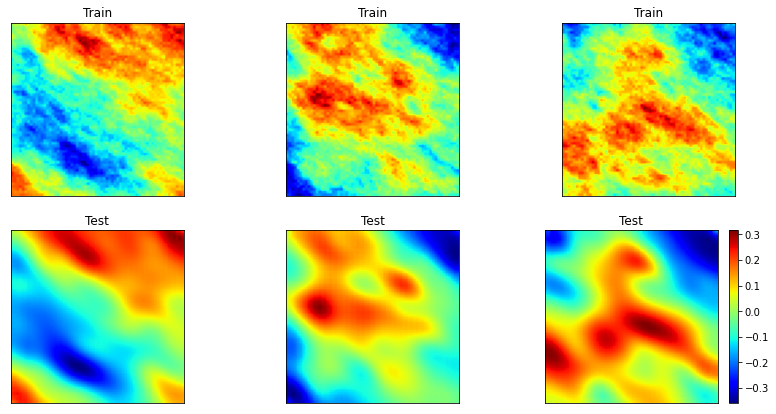

In [29]:
pred16_16fmultiscale,pred32_32fmultiscale,pred64_64fmultiscale  = multiscale.predict(test8_8cnndn)
print(pred16_16fmultiscale.shape)

#plot predictions from model
plot_reconstruction1(test16_16dn,pred16_16fmultiscale,16,16)
plot_reconstruction1(test32_32dn,pred32_32fmultiscale,32,32)
plot_reconstruction1(test64_64dn,pred64_64fmultiscale,64,64)

# Figures for Results section

## Compare performance of autoencoders

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred64_64fAE256_train  = AE256.predict(train64_64cnndn)
pred64_64fAE128_train  = AE128.predict(train64_64cnndn)
pred64_64fAE64_train  = AE64.predict(train64_64cnndn)

pred64_64fAE256_test  = AE256.predict(test64_64cnndn)
pred64_64fAE128_test  = AE128.predict(test64_64cnndn)
pred64_64fAE64_test  = AE64.predict(test64_64cnndn)

print(pred64_64fAE256_train.shape)
print(pred64_64fAE256_test.shape)

(4500, 64, 64, 1)
(500, 64, 64, 1)


In [31]:
def plot_reconstruction1(original,reconstruction,dim1,dim2,title):
  n = 3
  plt.figure(figsize=(13, 8))
  for i in range(n):
      # Display original
      RMSE=sqrt(mean_squared_error(np.reshape(original[i],(dim1*dim2)), np.reshape(reconstruction[i],(dim1*dim2))))        
      ax = plt.subplot(2, n, i + 1)
      plt.subplots_adjust(left=0.01,
                    bottom=0.01,
                    right=0.99,
                    top=0.99,
                    wspace=0.08,
                    hspace=0.08)
      plt.imshow(original[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Original fine test')
      plt.title('$m_{train}$',fontsize = 25)
      #plt.subplots_adjust(hspace = .02, wspace=.02)
      #plt.tight_layout() 
      plt.colorbar(shrink=0.85)
    
      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstruction[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Reconstructed test')
      plt.title('$\hat{m}_{train}$'+'  RMSE='+str(np.round(RMSE,decimals=3)),fontsize = 25)
      plt.colorbar(shrink=0.85)
  plt.savefig(title,dpi=500)
  plt.show()

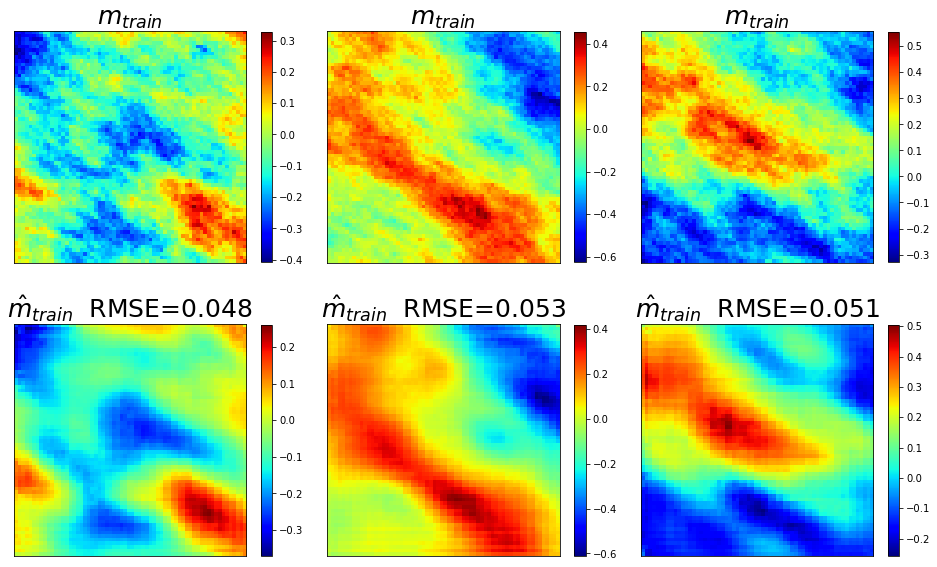

In [32]:
plot_reconstruction1(train64_64cnndn,pred64_64fAE256_train,64,64,'AE256_train.png')

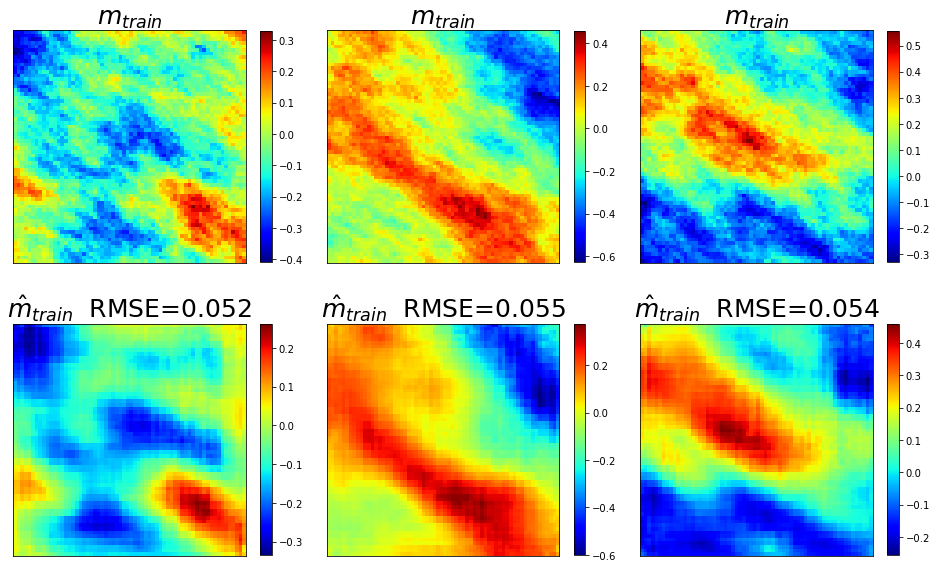

In [33]:
plot_reconstruction1(train64_64cnndn,pred64_64fAE128_train,64,64,'AE128_train.png')

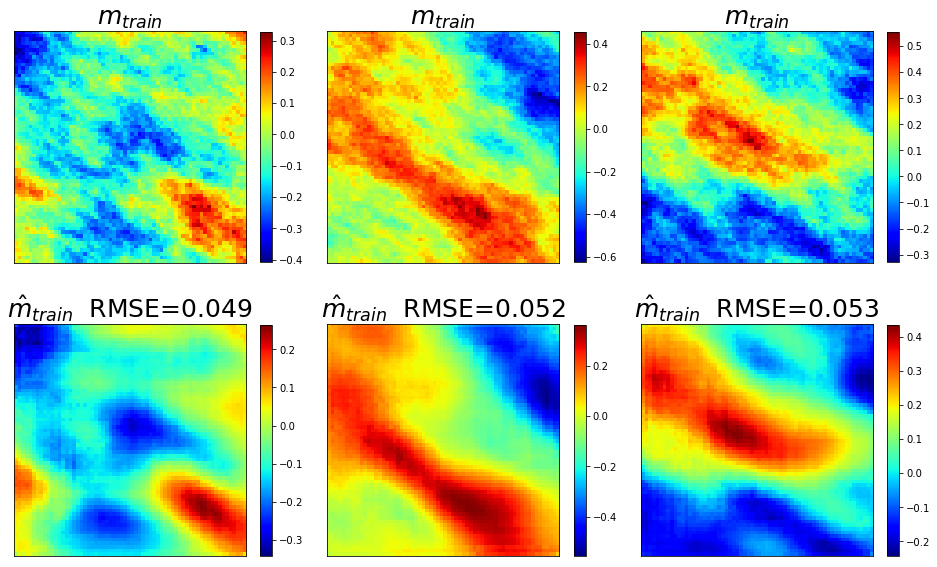

In [34]:
plot_reconstruction1(train64_64cnndn,pred64_64fAE64_train,64,64,'AE64_train.png')

In [35]:
def plot_reconstruction2(original,reconstruction,dim1,dim2,title):
  n = 3
  plt.figure(figsize=(13, 8))
  for i in range(n):
      # Display original
      RMSE=sqrt(mean_squared_error(np.reshape(original[i],(dim1*dim2)), np.reshape(reconstruction[i],(dim1*dim2))))       
      ax = plt.subplot(2, n, i + 1)
      plt.subplots_adjust(left=0.01,
                    bottom=0.01,
                    right=0.99,
                    top=0.99,
                    wspace=0.08,
                    hspace=0.08)
      plt.imshow(original[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Original fine test')
      plt.title('$m_{test}$',fontsize = 25)
      #plt.subplots_adjust(hspace = .02, wspace=.02)
      #plt.tight_layout() 
      plt.colorbar(shrink=0.85)
    
      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstruction[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Reconstructed test')
      plt.title('$\hat{m}_{test}$'+'  RMSE='+str(np.round(RMSE,decimals=3)),fontsize = 25)
      plt.colorbar(shrink=0.85)
  plt.savefig(title,dpi=500)
  plt.show()

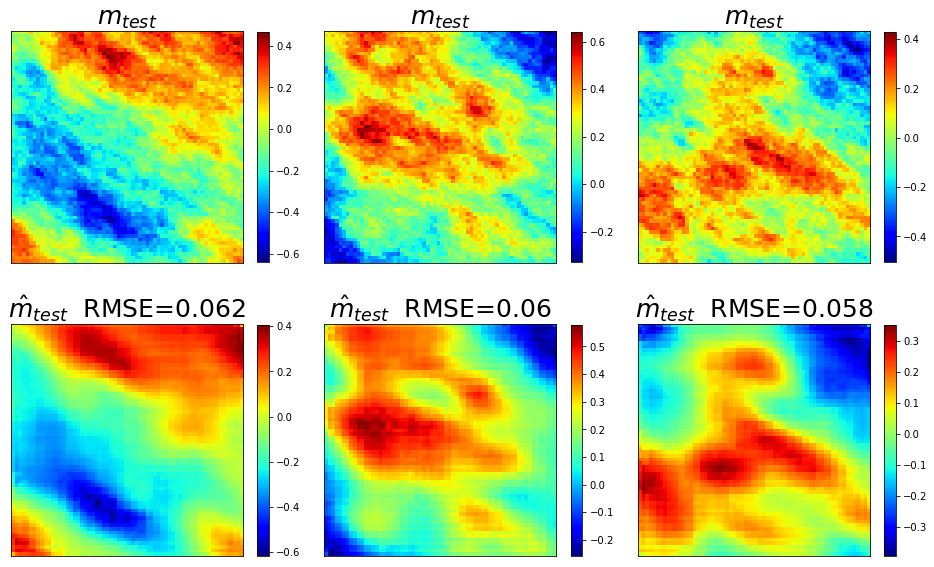

In [36]:
plot_reconstruction2(test64_64cnndn,pred64_64fAE256_test,64,64,'AE256_test.png')

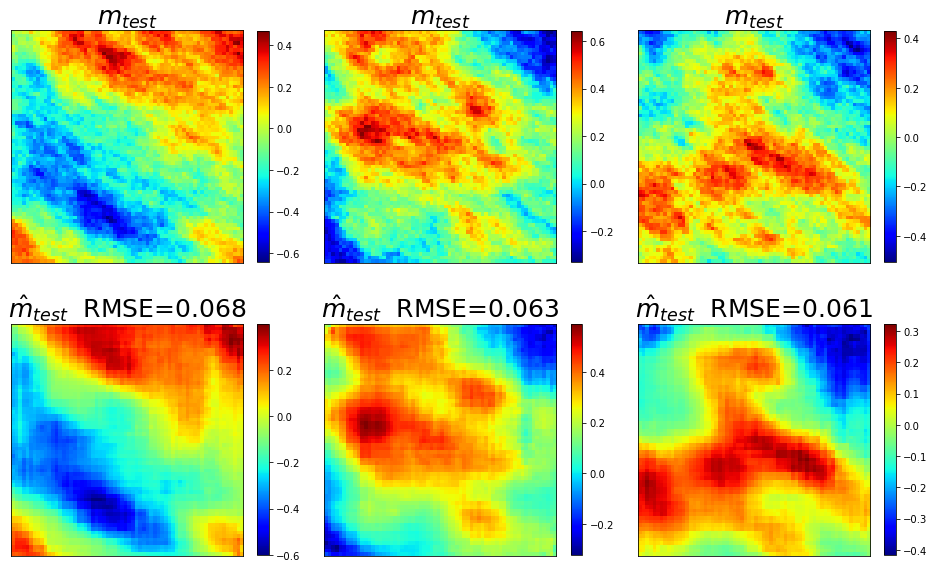

In [37]:
plot_reconstruction2(test64_64cnndn,pred64_64fAE128_test,64,64,'AE128_test.png')

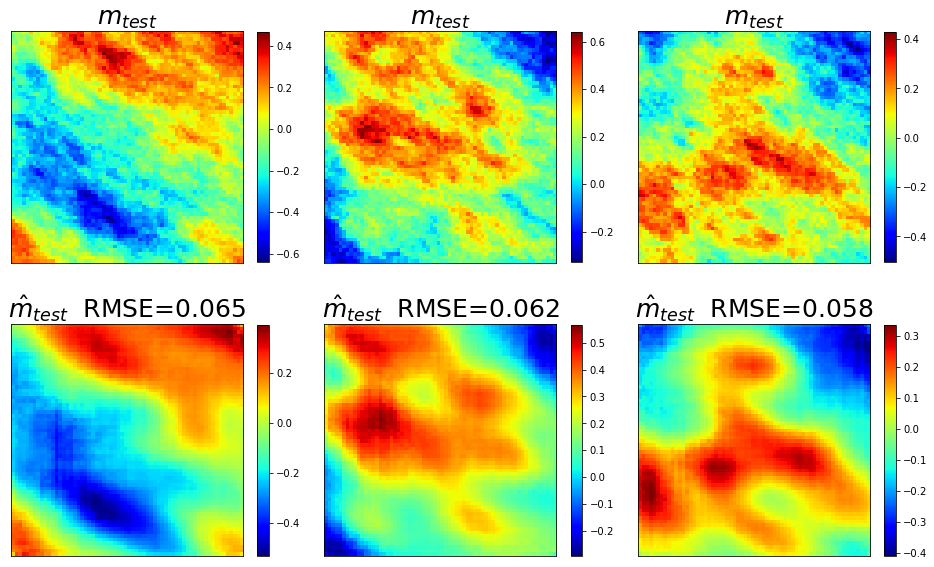

In [38]:
plot_reconstruction2(test64_64cnndn,pred64_64fAE64_test,64,64,'AE64_test.png')

In [39]:
pred16_16fmultiscale_train,pred32_32fmultiscale_train,pred64_64fmultiscale_train  = multiscale.predict(train8_8cnndn)

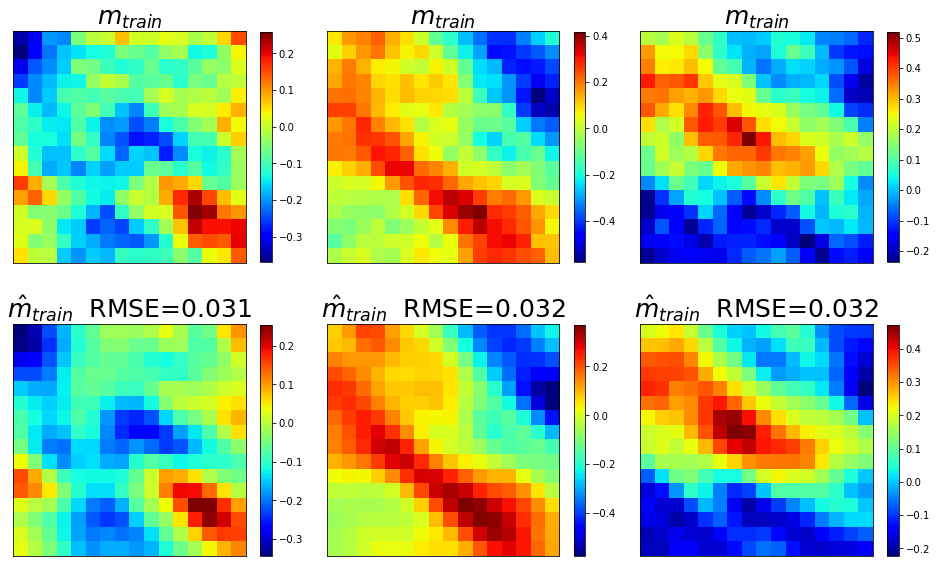

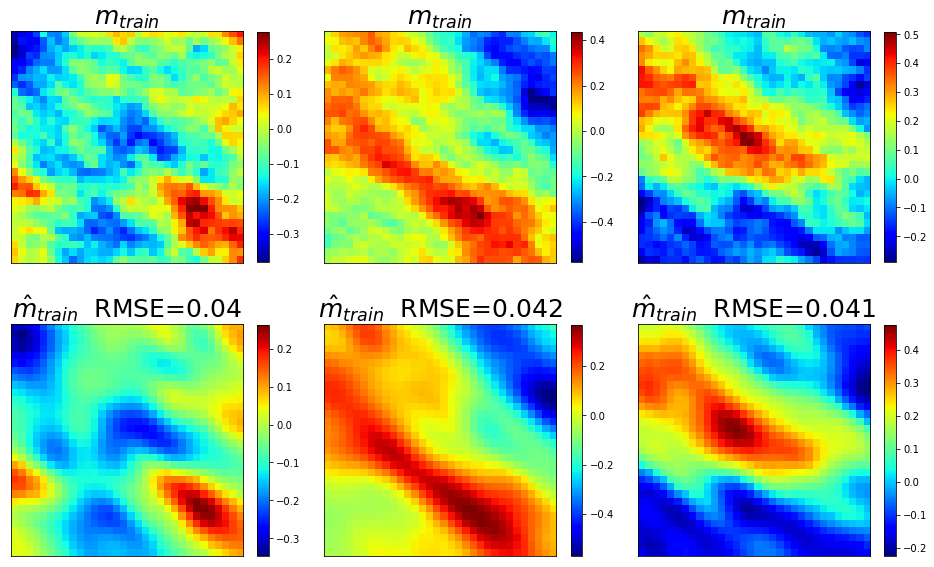

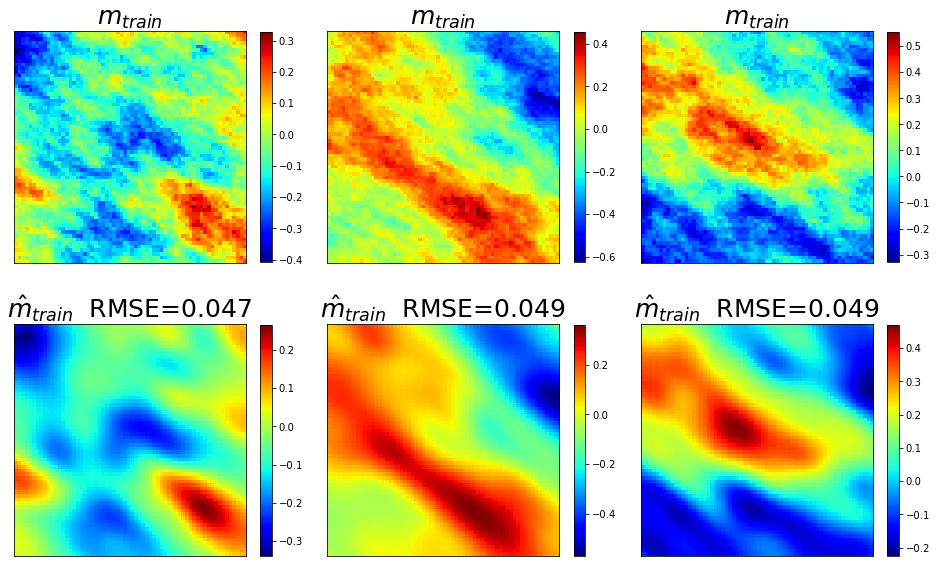

In [40]:
plot_reconstruction1(train16_16dn,pred16_16fmultiscale_train,16,16,'pred16_16fmultiscale_train.png')
plot_reconstruction1(train32_32dn,pred32_32fmultiscale_train,32,32,'pred32_32fmultiscale_train.png')
plot_reconstruction1(train64_64dn,pred64_64fmultiscale_train,64,64,'pred64_64fmultiscale_train.png')

In [41]:
pred16_16fmultiscale_test,pred32_32fmultiscale_test,pred64_64fmultiscale_test  = multiscale.predict(test8_8cnndn)

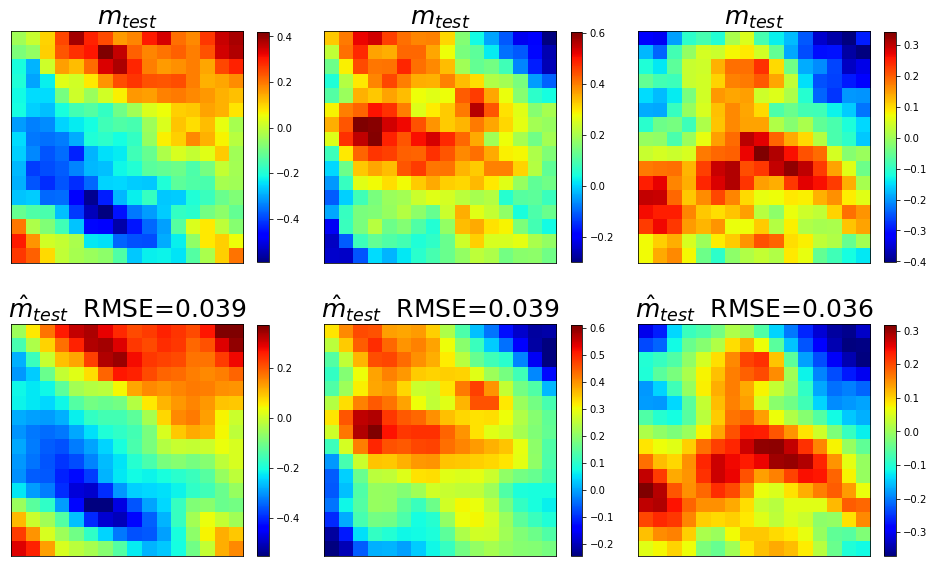

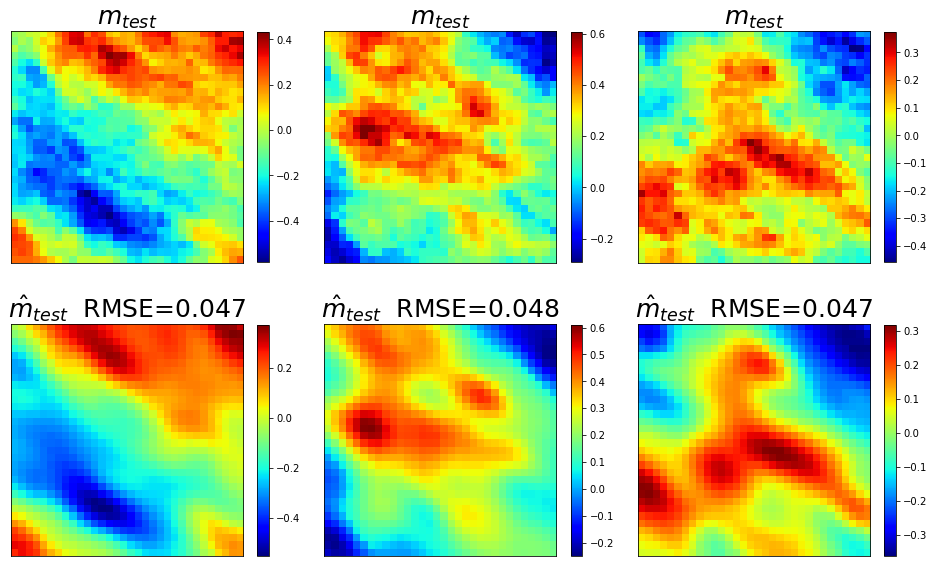

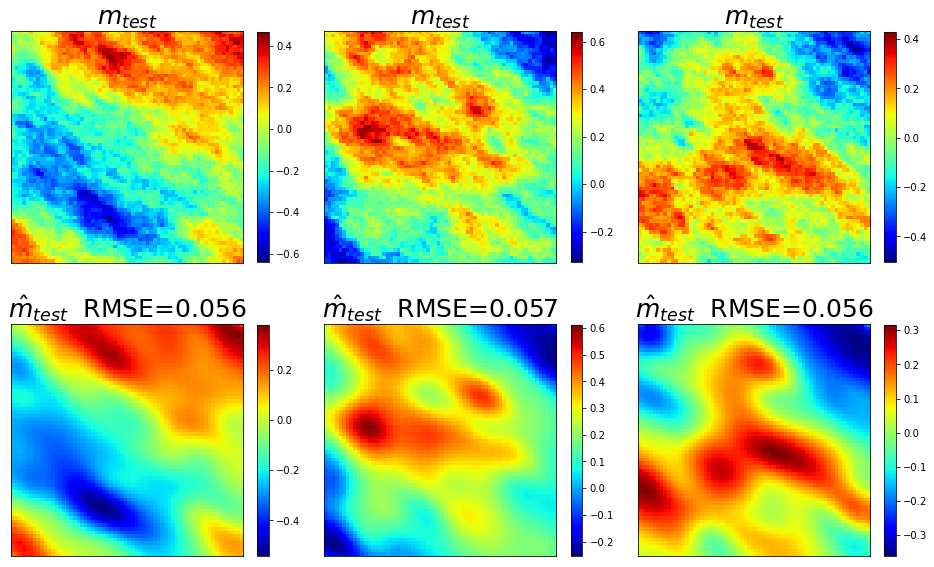

In [42]:
plot_reconstruction2(test16_16dn,pred16_16fmultiscale_test,16,16,'pred16_16fmultiscale_test.png')
plot_reconstruction2(test32_32dn,pred32_32fmultiscale_test,32,32,'pred32_32fmultiscale_test.png')
plot_reconstruction2(test64_64dn,pred64_64fmultiscale_test,64,64,'pred64_64fmultiscale_test.png')

In [43]:
def plot_reconstruction3(true,original,reconstruction,dim1,dim2,title):
  n = 3
  plt.figure(figsize=(13, 10))
  for i in range(n):
      # Display original
      #RMSE=sqrt(mean_squared_error(np.reshape(original[i],(dim1*dim2)), np.reshape(reconstruction[i],(dim1*dim2))))       
      ax = plt.subplot(3, n, i + 1)
      plt.subplots_adjust(left=0.01,
                    bottom=0.01,
                    right=0.99,
                    top=0.99,
                    wspace=0.02,
                    hspace=0.25)
      plt.imshow(true[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Original fine test')
      plt.title('$m_{test}$',fontsize = 25)
      #plt.subplots_adjust(hspace = .02, wspace=.02)
      #plt.tight_layout() 
      plt.colorbar(shrink=0.85)
    
      # Display reconstruction
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(original[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Reconstructed test')
      plt.title('$\hat{m}_{test-AE}$',fontsize = 25)
      plt.colorbar(shrink=0.85)
      # Display reconstruction
      ax = plt.subplot(3, n, i + 1 + 2*n)
      plt.imshow(reconstruction[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Reconstructed test')
      plt.title('$\hat{m}_{test-Multiscale}$',fontsize = 25)
      plt.colorbar(shrink=0.85)
  plt.savefig(title,dpi=500)
  plt.show()

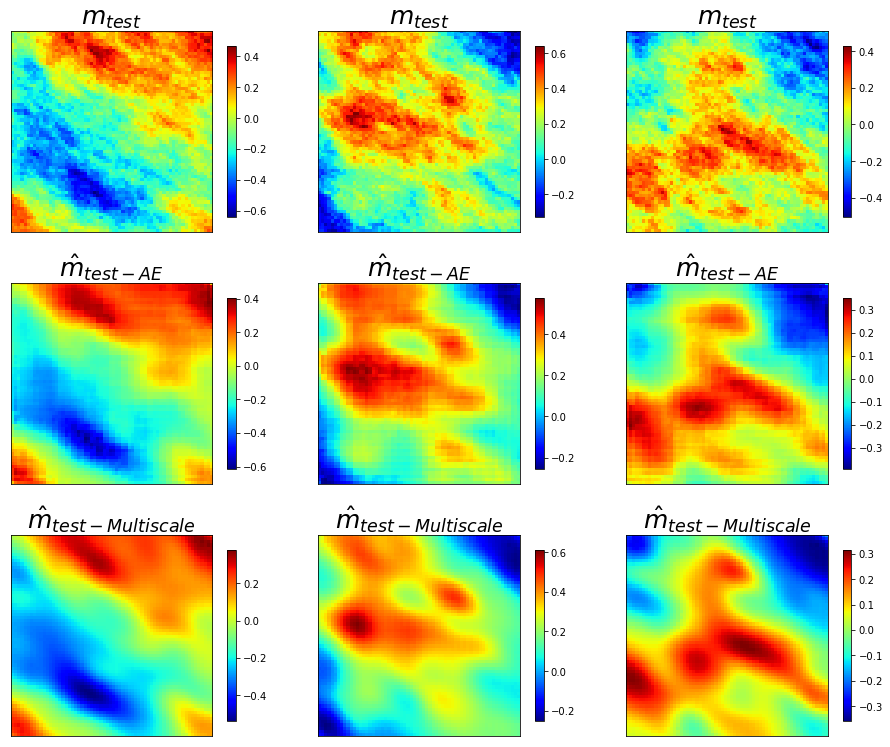

In [44]:
plot_reconstruction3(test64_64dn,pred64_64fAE256_test,pred64_64fmultiscale_test,64,64,'test64_AE256_64_multi64.png')

## Histograms and scatterplots

In [45]:
pred64_64fAE256_train.flatten().shape

(18432000,)

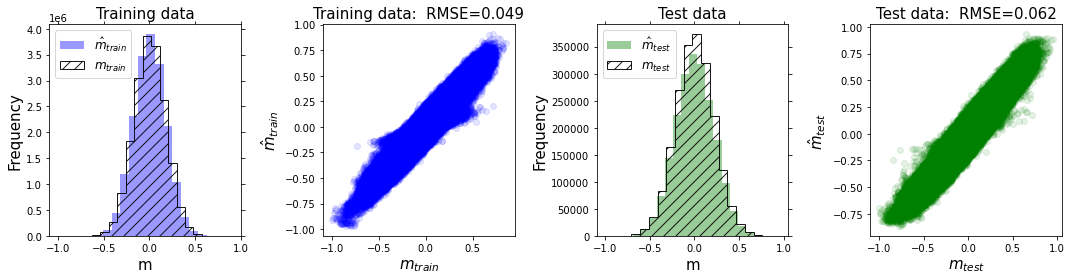

In [46]:
# Autoencoder

RMSE_train_AE=sqrt(mean_squared_error(pred64_64fAE256_train.flatten(), train64_64dn.flatten()))
fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)


plt.hist(pred64_64fAE256_train.flatten(), color='blue', alpha=0.4, bins=20, label="$\hat{m}_{train}$")
plt.hist(train64_64dn.flatten(), color='blue', alpha=0.9, hatch='//', edgecolor='black', histtype='step', bins=20, label="$m_{train}$")
plt.tick_params(axis='both', which='both', bottom='on', top='off', labelbottom='on', right='off', left='off', labelleft='off')
plt.title('Training data',fontsize = 15)
plt.xlabel("m",fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)
plt.legend(loc=2, prop={'size': 12})

    
plt.subplot(1, 4, 2)
plt.scatter(train64_64dn.flatten(),pred64_64fAE256_train.flatten(), color='blue', alpha=0.1)
plt.title('Training data'+':  RMSE='+str(np.round(RMSE_train_AE,decimals=3)),fontsize = 15)
plt.xlabel("$m_{train}$",fontsize = 15)
plt.ylabel("$\hat{m}_{train}$",fontsize = 15)


RMSE_test_AE=sqrt(mean_squared_error(pred64_64fAE256_test.flatten(), test64_64dn.flatten()))
plt.subplot(1, 4, 3)
plt.hist(pred64_64fAE256_test.flatten(), color='green', alpha=0.4, bins=20, label="$\hat{m}_{test}$")
plt.hist(test64_64dn.flatten(), color='green', alpha=0.9, hatch='//', edgecolor='black', histtype='step', bins=20, label="$m_{test}$")
plt.tick_params(axis='both', which='both', bottom='on', top='off', labelbottom='on', right='off', left='off', labelleft='off')
plt.title('Test data',fontsize = 15)
plt.xlabel("m",fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)
plt.legend(loc=2, prop={'size': 12})


plt.subplot(1, 4, 4)
plt.scatter(test64_64dn.flatten(),pred64_64fAE256_test.flatten(), color='green', alpha=0.1)
plt.title('Test data'+':  RMSE='+str(np.round(RMSE_test_AE,decimals=3)),fontsize = 15)
plt.xlabel("$m_{test}$",fontsize = 15)
plt.ylabel("$\hat{m}_{test}$",fontsize = 15)
plt.tight_layout()

#plt.savefig('Evaluation_AE',dpi=500)

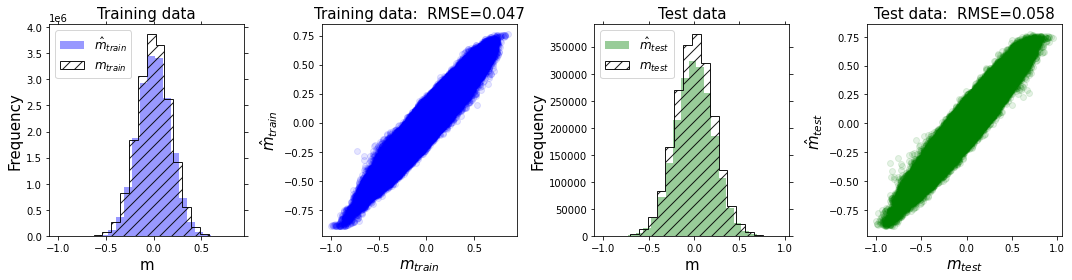

In [47]:
# Multiscale

RMSE_train_MS=sqrt(mean_squared_error(pred64_64fmultiscale_train.flatten(), train64_64dn.flatten()))
fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)


plt.hist(pred64_64fmultiscale_train.flatten(), color='blue', alpha=0.4, bins=20, label="$\hat{m}_{train}$")
plt.hist(train64_64dn.flatten(), color='blue', alpha=0.9, hatch='//', edgecolor='black', histtype='step', bins=20, label="$m_{train}$")
plt.tick_params(axis='both', which='both', bottom='on', top='off', labelbottom='on', right='off', left='off', labelleft='off')
plt.title('Training data',fontsize = 15)
plt.xlabel("m",fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)
plt.legend(loc=2, prop={'size': 12})
    
plt.subplot(1, 4, 2)
plt.scatter(train64_64dn.flatten(),pred64_64fmultiscale_train.flatten(), color='blue', alpha=0.1)
plt.title('Training data'+':  RMSE='+str(np.round(RMSE_train_MS,decimals=3)),fontsize = 15)
plt.xlabel("$m_{train}$",fontsize = 15)
plt.ylabel("$\hat{m}_{train}$",fontsize = 15)


RMSE_test_MS=sqrt(mean_squared_error(pred64_64fmultiscale_test.flatten(), test64_64dn.flatten()))
plt.subplot(1, 4, 3)
plt.hist(pred64_64fmultiscale_test.flatten(), color='green', alpha=0.4, bins=20, label="$\hat{m}_{test}$")
plt.hist(test64_64dn.flatten(), color='green', alpha=0.9, hatch='//', edgecolor='black', histtype='step', bins=20, label="$m_{test}$")
plt.tick_params(axis='both', which='both', bottom='on', top='off', labelbottom='on', right='off', left='off', labelleft='off')
plt.title('Test data',fontsize = 15)
plt.xlabel("m",fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)
plt.legend(loc=2, prop={'size': 12})


plt.subplot(1, 4, 4)
plt.scatter(test64_64dn.flatten(),pred64_64fmultiscale_test.flatten(), color='green', alpha=0.1)
plt.title('Test data'+':  RMSE='+str(np.round(RMSE_test_MS,decimals=3)),fontsize = 15)
plt.xlabel("$m_{test}$",fontsize = 15)
plt.ylabel("$\hat{m}_{test}$",fontsize = 15)
plt.tight_layout()

### save models

In [ ]:
AE64.save('AE64.h5')
AE128.save('AE128.h5')
AE256.save('AE256.h5')
multiscale.save('multiscale.h5')

In [49]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
